In [ ]:
import os
import datetime
import cv2
import imageio
import skimage
import scipy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from skimage.transform import resize
from IPython.display import Image

In [ ]:
class DataLoader():
    def __init__(self, img_res=(128, 128)):
        self.img_res = img_res

    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "concat_image_sketch" if not is_testing else "val"
        path = glob(os.path.join(os.getcwd(), '{}'.format(data_type), '*'))
        self.n_batches = int(len(path) / batch_size)

        for i in range(self.n_batches-1):
            batch = path[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [],[]
            for img in batch:
                img = self.imread(img)
                h, w, _ = img.shape
                half_w = w//2
                img_A = img[:, :half_w, :]
                img_B = img[:, half_w:, :]

                img_A = resize(img_A, self.img_res)
                img_B = resize(img_B, self.img_res)

                if not is_testing and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B


    def imread(self, path):
        return imageio.imread(path).astype(np.float)

In [ ]:
class MyModel():
    def __init__(self):
        # Input shape
        self.img_rows = 256
        self.img_cols = 256
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.data_loader = DataLoader(img_res=(self.img_rows, self.img_cols))


        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 64
        self.df = 64

        optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generator
        #-------------------------

        # Build the generator
        self.generator = self.build_generator()

        # Input images and their conditioning images
        img_A = tf.keras.layers.Input(shape=self.img_shape)
        img_B = tf.keras.layers.Input(shape=self.img_shape)

        # By conditioning on B generate a fake version of A
        fake_A = self.generator(img_B)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # Discriminators determines validity of translated images / condition pairs
        valid = self.discriminator([fake_A, img_B])

        self.combined = tf.keras.models.Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
        self.combined.compile(loss=['mse', 'mae'],
                              loss_weights=[1, 100],
                              optimizer=optimizer)
    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = tf.keras.layers.Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
            if bn:
                d = tf.keras.layers.BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = tf.keras.layers.UpSampling2D(size=2)(layer_input)
            u = tf.keras.layers.Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = tf.keras.layers.Dropout(dropout_rate)(u)
            u = tf.keras.layers.BatchNormalization(momentum=0.8)(u)
            u = tf.keras.layers.Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = tf.keras.layers.Input(shape=self.img_shape)
        
        # Downsampling
        d1 = conv2d(d0, self.gf, bn=False)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)
        d5 = conv2d(d4, self.gf*8)
        d6 = conv2d(d5, self.gf*8)
        d7 = conv2d(d6, self.gf*8)

        # Upsampling
        u1 = deconv2d(d7, d6, self.gf*8)
        u2 = deconv2d(u1, d5, self.gf*8)
        u3 = deconv2d(u2, d4, self.gf*8)
        u4 = deconv2d(u3, d3, self.gf*4)
        u5 = deconv2d(u4, d2, self.gf*2)
        u6 = deconv2d(u5, d1, self.gf)

        u7 = tf.keras.layers.UpSampling2D(size=2)(u6)
        output_img = tf.keras.layers.Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

        return tf.keras.models.Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, bn=True):
            """Discriminator layer"""
            d = tf.keras.layers.Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
            if bn:
                d = tf.keras.layers.BatchNormalization(momentum=0.8)(d)
            return d

        img_A = tf.keras.layers.Input(shape=self.img_shape)
        img_B = tf.keras.layers.Input(shape=self.img_shape)

        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = tf.keras.layers.Concatenate(axis=-1)([img_A, img_B])

        d1 = d_layer(combined_imgs, self.df, bn=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = tf.keras.layers.Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return tf.keras.models.Model([img_A, img_B], validity)

    def save_imgs(self,epoch):
      # r, c = 256, 256
      # noise = np.random.normal(0, 1, (1, r , c, 3))
      noise=cv2.imread("/content/input_sketch_3.jpg")
      noise=resize(noise,(256,256,3))
      noise=noise.reshape((1,256,256,3))
      gen_imgs = self.generator.predict(noise)
      gen_imgs=gen_imgs.reshape((256,256,3))
      plt.imshow(gen_imgs)
      plt.savefig("/content/generated/gen_%d.jpg" % epoch)
      print("saving...")
      plt.close()

    def train(self, epochs, batch_size=1, sample_interval=50):
        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):
                # ---------------------
                #  Train Discriminator
                # ---------------------
                # Condition on B and generate a translated version
                fake_A = self.generator.predict(imgs_B)

                # Train the discriminators (original images = real / generated = Fake)
                d_loss_real = self.discriminator.train_on_batch([imgs_A, imgs_B], valid)
                d_loss_fake = self.discriminator.train_on_batch([fake_A, imgs_B], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # -----------------
                #  Train Generator
                # -----------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])

                elapsed_time = datetime.datetime.now() - start_time
                # Plot the progress
                print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % (epoch+1, epochs,
                                                                        batch_i+1, self.data_loader.n_batches,
                                                                        d_loss[0], 100*d_loss[1],
                                                                        g_loss[0],
                                                                        elapsed_time))
            # If at save interval => save generated image samples
            if (epoch+1) % sample_interval == 0:
              self.save_imgs(epoch+1)

In [ ]:
with tf.device('/GPU:0'):
  gan = MyModel()
  gan.train(epochs=200, batch_size=5, sample_interval=5)
  gan.generator.save('model_generator.h5')
  gan.discriminator.save('model_discriminator.h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[Epoch 1/200] [Batch 1/20] [D loss: 14.501866, acc:  49%] [G loss: 65.661354] time: 0:00:18.281686
[Epoch 1/200] [Batch 2/20] [D loss: 18.558286, acc:  43%] [G loss: 55.739204] time: 0:00:19.210760
[Epoch 1/200] [Batch 3/20] [D loss: 10.287117, acc:  54%] [G loss: 46.936600] time: 0:00:19.847264
[Epoch 1/200] [Batch 4/20] [D loss: 3.551544, acc:  40%] [G loss: 46.811466] time: 0:00:20.811072
[Epoch 1/200] [Batch 5/20] [D loss: 1.353984, acc:  53%] [G loss: 41.225109] time: 0:00:21.610988
[Epoch 1/200] [Batch 6/20] [D loss: 0.893561, acc:  49%] [G loss: 35.699116] time: 0:00:22.214897
[Epoch 1/200] [Batch 7/20] [D loss: 0.719165, acc:  52%] [G loss: 31.584301] time: 0:00:22.813709
[Epoch 1/200] [Batch 8/20] [D loss: 0.662768, acc:  51%] [G loss: 37.051327] time: 0:00:23.414897
[Epoch 1/200] [Batch 9/20] [D loss: 0.634793, acc:  52%] [G loss: 37.380184] time: 0:00:24.013843
[Epoch 1/200] [Batch 10/20] [D loss: 0.564422, acc:  50%] [G loss: 32.174309] time: 0:00:24.615574
[Epoch 1/200] [B

saving...
[Epoch 6/200] [Batch 1/20] [D loss: 0.294110, acc:  59%] [G loss: 19.667852] time: 0:01:19.480086
[Epoch 6/200] [Batch 2/20] [D loss: 0.268048, acc:  53%] [G loss: 18.243525] time: 0:01:20.167903
[Epoch 6/200] [Batch 3/20] [D loss: 0.281586, acc:  55%] [G loss: 19.259840] time: 0:01:20.849107
[Epoch 6/200] [Batch 4/20] [D loss: 0.375709, acc:  53%] [G loss: 19.081791] time: 0:01:21.532913
[Epoch 6/200] [Batch 5/20] [D loss: 0.295136, acc:  60%] [G loss: 18.623774] time: 0:01:22.227230
[Epoch 6/200] [Batch 6/20] [D loss: 0.277700, acc:  49%] [G loss: 21.084459] time: 0:01:22.845123
[Epoch 6/200] [Batch 7/20] [D loss: 0.339946, acc:  44%] [G loss: 19.087427] time: 0:01:23.525436
[Epoch 6/200] [Batch 8/20] [D loss: 0.321168, acc:  51%] [G loss: 26.559565] time: 0:01:24.149867
[Epoch 6/200] [Batch 9/20] [D loss: 0.248435, acc:  61%] [G loss: 27.173168] time: 0:01:24.759904
[Epoch 6/200] [Batch 10/20] [D loss: 0.257038, acc:  62%] [G loss: 20.214712] time: 0:01:25.396856
[Epoch 6/

[Epoch 10/200] [Batch 19/20] [D loss: 0.333500, acc:  59%] [G loss: 22.313469] time: 0:02:19.352435
saving...
[Epoch 11/200] [Batch 1/20] [D loss: 0.312840, acc:  60%] [G loss: 17.192991] time: 0:02:20.209816
[Epoch 11/200] [Batch 2/20] [D loss: 0.256479, acc:  57%] [G loss: 13.515297] time: 0:02:20.836091
[Epoch 11/200] [Batch 3/20] [D loss: 0.274296, acc:  49%] [G loss: 15.902985] time: 0:02:21.459142
[Epoch 11/200] [Batch 4/20] [D loss: 0.270592, acc:  54%] [G loss: 16.855282] time: 0:02:22.163495
[Epoch 11/200] [Batch 5/20] [D loss: 0.241090, acc:  54%] [G loss: 14.476926] time: 0:02:22.781877
[Epoch 11/200] [Batch 6/20] [D loss: 0.241089, acc:  62%] [G loss: 19.625601] time: 0:02:23.484455
[Epoch 11/200] [Batch 7/20] [D loss: 0.366571, acc:  58%] [G loss: 17.047335] time: 0:02:24.188351
[Epoch 11/200] [Batch 8/20] [D loss: 0.262815, acc:  68%] [G loss: 22.185902] time: 0:02:24.846497
[Epoch 11/200] [Batch 9/20] [D loss: 0.226163, acc:  61%] [G loss: 21.420496] time: 0:02:25.793701

[Epoch 15/200] [Batch 19/20] [D loss: 0.380755, acc:  60%] [G loss: 15.184848] time: 0:03:22.123404
saving...
[Epoch 16/200] [Batch 1/20] [D loss: 0.376312, acc:  51%] [G loss: 14.371587] time: 0:03:22.983350
[Epoch 16/200] [Batch 2/20] [D loss: 0.251855, acc:  58%] [G loss: 12.491739] time: 0:03:23.621121
[Epoch 16/200] [Batch 3/20] [D loss: 0.371960, acc:  49%] [G loss: 14.166048] time: 0:03:24.250288
[Epoch 16/200] [Batch 4/20] [D loss: 0.240952, acc:  62%] [G loss: 14.040317] time: 0:03:24.886770
[Epoch 16/200] [Batch 5/20] [D loss: 0.242306, acc:  54%] [G loss: 13.258557] time: 0:03:25.532522
[Epoch 16/200] [Batch 6/20] [D loss: 0.134104, acc:  84%] [G loss: 17.419247] time: 0:03:26.188234
[Epoch 16/200] [Batch 7/20] [D loss: 0.294816, acc:  59%] [G loss: 15.997431] time: 0:03:26.817740
[Epoch 16/200] [Batch 8/20] [D loss: 0.227184, acc:  69%] [G loss: 18.513769] time: 0:03:27.452830
[Epoch 16/200] [Batch 9/20] [D loss: 0.192514, acc:  69%] [G loss: 18.174839] time: 0:03:28.097674

[Epoch 20/200] [Batch 19/20] [D loss: 0.143144, acc:  86%] [G loss: 14.807076] time: 0:04:24.763509
saving...
[Epoch 21/200] [Batch 1/20] [D loss: 0.392734, acc:  54%] [G loss: 12.607654] time: 0:04:25.630293
[Epoch 21/200] [Batch 2/20] [D loss: 0.185462, acc:  74%] [G loss: 12.219082] time: 0:04:26.275420
[Epoch 21/200] [Batch 3/20] [D loss: 0.290408, acc:  56%] [G loss: 12.770465] time: 0:04:26.983483
[Epoch 21/200] [Batch 4/20] [D loss: 0.121079, acc:  85%] [G loss: 13.327562] time: 0:04:27.630898
[Epoch 21/200] [Batch 5/20] [D loss: 0.121392, acc:  86%] [G loss: 12.693994] time: 0:04:28.337189
[Epoch 21/200] [Batch 6/20] [D loss: 0.141099, acc:  94%] [G loss: 18.818012] time: 0:04:29.027298
[Epoch 21/200] [Batch 7/20] [D loss: 0.287006, acc:  60%] [G loss: 12.610390] time: 0:04:29.747639
[Epoch 21/200] [Batch 8/20] [D loss: 0.181526, acc:  79%] [G loss: 15.692141] time: 0:04:30.693277
[Epoch 21/200] [Batch 9/20] [D loss: 0.200033, acc:  79%] [G loss: 15.139786] time: 0:04:31.482894

[Epoch 25/200] [Batch 19/20] [D loss: 0.050403, acc:  96%] [G loss: 12.804293] time: 0:05:28.080969
saving...
[Epoch 26/200] [Batch 1/20] [D loss: 0.213199, acc:  67%] [G loss: 11.223407] time: 0:05:28.987918
[Epoch 26/200] [Batch 2/20] [D loss: 0.097917, acc:  95%] [G loss: 10.465809] time: 0:05:29.639307
[Epoch 26/200] [Batch 3/20] [D loss: 0.221292, acc:  71%] [G loss: 13.376169] time: 0:05:30.284238
[Epoch 26/200] [Batch 4/20] [D loss: 0.074093, acc:  95%] [G loss: 12.662394] time: 0:05:30.935999
[Epoch 26/200] [Batch 5/20] [D loss: 0.157949, acc:  79%] [G loss: 12.522220] time: 0:05:31.588004
[Epoch 26/200] [Batch 6/20] [D loss: 0.051717, acc:  97%] [G loss: 17.143492] time: 0:05:32.227892
[Epoch 26/200] [Batch 7/20] [D loss: 0.303003, acc:  65%] [G loss: 12.014821] time: 0:05:32.879920
[Epoch 26/200] [Batch 8/20] [D loss: 0.203531, acc:  78%] [G loss: 12.065145] time: 0:05:33.523833
[Epoch 26/200] [Batch 9/20] [D loss: 0.064737, acc:  96%] [G loss: 14.664274] time: 0:05:34.231404

[Epoch 30/200] [Batch 19/20] [D loss: 0.042485, acc:  99%] [G loss: 11.005227] time: 0:06:30.716588
saving...
[Epoch 31/200] [Batch 1/20] [D loss: 0.145911, acc:  82%] [G loss: 11.507607] time: 0:06:31.586457
[Epoch 31/200] [Batch 2/20] [D loss: 0.078446, acc:  95%] [G loss: 11.912055] time: 0:06:32.306072
[Epoch 31/200] [Batch 3/20] [D loss: 0.263198, acc:  70%] [G loss: 10.067800] time: 0:06:33.029977
[Epoch 31/200] [Batch 4/20] [D loss: 0.075834, acc:  96%] [G loss: 10.249099] time: 0:06:33.684585
[Epoch 31/200] [Batch 5/20] [D loss: 0.113774, acc:  93%] [G loss: 9.972982] time: 0:06:34.515274
[Epoch 31/200] [Batch 6/20] [D loss: 0.042187, acc:  98%] [G loss: 14.597713] time: 0:06:35.419259
[Epoch 31/200] [Batch 7/20] [D loss: 0.220002, acc:  71%] [G loss: 10.610816] time: 0:06:36.148566
[Epoch 31/200] [Batch 8/20] [D loss: 0.099610, acc:  89%] [G loss: 10.503486] time: 0:06:36.800892
[Epoch 31/200] [Batch 9/20] [D loss: 0.065894, acc:  96%] [G loss: 12.475327] time: 0:06:37.440787


[Epoch 35/200] [Batch 19/20] [D loss: 0.065597, acc:  96%] [G loss: 10.116497] time: 0:07:34.162766
saving...
[Epoch 36/200] [Batch 1/20] [D loss: 0.157750, acc:  79%] [G loss: 9.819417] time: 0:07:35.050394
[Epoch 36/200] [Batch 2/20] [D loss: 0.084673, acc:  91%] [G loss: 10.118036] time: 0:07:35.692514
[Epoch 36/200] [Batch 3/20] [D loss: 0.221828, acc:  71%] [G loss: 9.170320] time: 0:07:36.330611
[Epoch 36/200] [Batch 4/20] [D loss: 0.108357, acc:  93%] [G loss: 10.320600] time: 0:07:36.980739
[Epoch 36/200] [Batch 5/20] [D loss: 0.077321, acc:  95%] [G loss: 10.410326] time: 0:07:37.622153
[Epoch 36/200] [Batch 6/20] [D loss: 0.045926, acc:  97%] [G loss: 13.333258] time: 0:07:38.259098
[Epoch 36/200] [Batch 7/20] [D loss: 0.220975, acc:  71%] [G loss: 9.226734] time: 0:07:38.904176
[Epoch 36/200] [Batch 8/20] [D loss: 0.309606, acc:  50%] [G loss: 11.240255] time: 0:07:39.555530
[Epoch 36/200] [Batch 9/20] [D loss: 0.204363, acc:  70%] [G loss: 12.384441] time: 0:07:40.201338
[E

[Epoch 40/200] [Batch 19/20] [D loss: 0.082755, acc:  95%] [G loss: 9.613282] time: 0:08:36.554274
saving...
[Epoch 41/200] [Batch 1/20] [D loss: 0.154701, acc:  81%] [G loss: 10.009444] time: 0:08:37.490611
[Epoch 41/200] [Batch 2/20] [D loss: 0.091516, acc:  89%] [G loss: 9.029160] time: 0:08:38.131663
[Epoch 41/200] [Batch 3/20] [D loss: 0.251853, acc:  73%] [G loss: 9.324941] time: 0:08:38.768519
[Epoch 41/200] [Batch 4/20] [D loss: 0.104209, acc:  89%] [G loss: 9.020838] time: 0:08:39.407249
[Epoch 41/200] [Batch 5/20] [D loss: 0.157371, acc:  85%] [G loss: 10.188448] time: 0:08:40.118143
[Epoch 41/200] [Batch 6/20] [D loss: 0.057694, acc:  94%] [G loss: 13.315102] time: 0:08:40.764656
[Epoch 41/200] [Batch 7/20] [D loss: 0.179262, acc:  72%] [G loss: 10.857921] time: 0:08:41.408641
[Epoch 41/200] [Batch 8/20] [D loss: 0.190009, acc:  71%] [G loss: 9.604503] time: 0:08:42.211298
[Epoch 41/200] [Batch 9/20] [D loss: 0.083987, acc:  93%] [G loss: 11.472824] time: 0:08:43.139429
[Epo

[Epoch 45/200] [Batch 19/20] [D loss: 0.051034, acc:  98%] [G loss: 8.726364] time: 0:09:39.996692
saving...
[Epoch 46/200] [Batch 1/20] [D loss: 0.115520, acc:  85%] [G loss: 9.282357] time: 0:09:40.828822
[Epoch 46/200] [Batch 2/20] [D loss: 0.081822, acc:  92%] [G loss: 8.512518] time: 0:09:41.466118
[Epoch 46/200] [Batch 3/20] [D loss: 0.098387, acc:  89%] [G loss: 7.916083] time: 0:09:42.103574
[Epoch 46/200] [Batch 4/20] [D loss: 0.129121, acc:  90%] [G loss: 8.124928] time: 0:09:42.755318
[Epoch 46/200] [Batch 5/20] [D loss: 0.105292, acc:  90%] [G loss: 8.422938] time: 0:09:43.396001
[Epoch 46/200] [Batch 6/20] [D loss: 0.064294, acc:  95%] [G loss: 10.988771] time: 0:09:44.105012
[Epoch 46/200] [Batch 7/20] [D loss: 0.088593, acc:  91%] [G loss: 8.667751] time: 0:09:44.746481
[Epoch 46/200] [Batch 8/20] [D loss: 0.088701, acc:  92%] [G loss: 9.708921] time: 0:09:45.397935
[Epoch 46/200] [Batch 9/20] [D loss: 0.046345, acc:  98%] [G loss: 12.478041] time: 0:09:46.029499
[Epoch 

[Epoch 50/200] [Batch 19/20] [D loss: 0.041686, acc:  99%] [G loss: 11.130247] time: 0:10:42.361324
saving...
[Epoch 51/200] [Batch 1/20] [D loss: 0.061800, acc:  95%] [G loss: 9.934277] time: 0:10:43.225592
[Epoch 51/200] [Batch 2/20] [D loss: 0.059317, acc:  97%] [G loss: 11.706192] time: 0:10:43.863490
[Epoch 51/200] [Batch 3/20] [D loss: 0.133137, acc:  83%] [G loss: 8.235697] time: 0:10:44.571787
[Epoch 51/200] [Batch 4/20] [D loss: 0.120440, acc:  94%] [G loss: 9.895635] time: 0:10:45.283458
[Epoch 51/200] [Batch 5/20] [D loss: 0.093808, acc:  92%] [G loss: 9.979676] time: 0:10:45.934291
[Epoch 51/200] [Batch 6/20] [D loss: 0.052177, acc:  99%] [G loss: 11.651723] time: 0:10:46.571685
[Epoch 51/200] [Batch 7/20] [D loss: 0.125429, acc:  87%] [G loss: 8.935781] time: 0:10:47.211525
[Epoch 51/200] [Batch 8/20] [D loss: 0.059873, acc:  96%] [G loss: 9.571309] time: 0:10:47.858781
[Epoch 51/200] [Batch 9/20] [D loss: 0.029315, acc:  99%] [G loss: 9.659319] time: 0:10:48.509091
[Epoch

[Epoch 55/200] [Batch 19/20] [D loss: 0.041529, acc:  99%] [G loss: 7.442464] time: 0:11:45.798472
saving...
[Epoch 56/200] [Batch 1/20] [D loss: 0.048696, acc:  98%] [G loss: 8.723702] time: 0:11:46.676994
[Epoch 56/200] [Batch 2/20] [D loss: 0.041157, acc:  99%] [G loss: 9.155869] time: 0:11:47.351523
[Epoch 56/200] [Batch 3/20] [D loss: 0.079547, acc:  91%] [G loss: 6.660327] time: 0:11:48.064781
[Epoch 56/200] [Batch 4/20] [D loss: 0.129906, acc:  95%] [G loss: 7.562175] time: 0:11:48.709642
[Epoch 56/200] [Batch 5/20] [D loss: 0.089973, acc:  93%] [G loss: 7.554306] time: 0:11:49.353403
[Epoch 56/200] [Batch 6/20] [D loss: 0.053360, acc:  99%] [G loss: 9.325823] time: 0:11:49.999598
[Epoch 56/200] [Batch 7/20] [D loss: 0.094374, acc:  92%] [G loss: 7.956393] time: 0:11:50.676173
[Epoch 56/200] [Batch 8/20] [D loss: 0.080382, acc:  93%] [G loss: 7.675784] time: 0:11:51.327627
[Epoch 56/200] [Batch 9/20] [D loss: 0.037484, acc:  98%] [G loss: 9.532219] time: 0:11:51.972688
[Epoch 56

[Epoch 60/200] [Batch 19/20] [D loss: 0.035943, acc:  99%] [G loss: 7.487338] time: 0:12:49.230163
saving...
[Epoch 61/200] [Batch 1/20] [D loss: 0.034338, acc:  99%] [G loss: 8.908237] time: 0:12:50.102998
[Epoch 61/200] [Batch 2/20] [D loss: 0.038463, acc:  99%] [G loss: 7.643645] time: 0:12:50.816834
[Epoch 61/200] [Batch 3/20] [D loss: 0.037242, acc:  97%] [G loss: 6.901183] time: 0:12:51.464115
[Epoch 61/200] [Batch 4/20] [D loss: 0.105891, acc:  96%] [G loss: 7.475206] time: 0:12:52.110811
[Epoch 61/200] [Batch 5/20] [D loss: 0.053713, acc:  98%] [G loss: 7.001090] time: 0:12:52.850243
[Epoch 61/200] [Batch 6/20] [D loss: 0.047476, acc:  99%] [G loss: 8.957049] time: 0:12:53.578054
[Epoch 61/200] [Batch 7/20] [D loss: 0.082948, acc:  93%] [G loss: 7.828246] time: 0:12:54.480426
[Epoch 61/200] [Batch 8/20] [D loss: 0.041759, acc:  98%] [G loss: 8.675467] time: 0:12:55.317967
[Epoch 61/200] [Batch 9/20] [D loss: 0.028111, acc:  99%] [G loss: 9.539497] time: 0:12:56.024095
[Epoch 61

[Epoch 65/200] [Batch 19/20] [D loss: 0.057954, acc:  97%] [G loss: 8.139629] time: 0:13:52.889222
saving...
[Epoch 66/200] [Batch 1/20] [D loss: 0.032619, acc:  99%] [G loss: 8.301851] time: 0:13:53.828022
[Epoch 66/200] [Batch 2/20] [D loss: 0.050642, acc:  99%] [G loss: 8.688702] time: 0:13:54.466650
[Epoch 66/200] [Batch 3/20] [D loss: 0.046009, acc:  94%] [G loss: 7.054812] time: 0:13:55.111140
[Epoch 66/200] [Batch 4/20] [D loss: 0.083938, acc:  99%] [G loss: 7.300500] time: 0:13:55.747309
[Epoch 66/200] [Batch 5/20] [D loss: 0.048719, acc:  97%] [G loss: 7.926237] time: 0:13:56.388400
[Epoch 66/200] [Batch 6/20] [D loss: 0.029748, acc: 100%] [G loss: 8.262691] time: 0:13:57.031089
[Epoch 66/200] [Batch 7/20] [D loss: 0.094871, acc:  90%] [G loss: 8.324231] time: 0:13:57.672325
[Epoch 66/200] [Batch 8/20] [D loss: 0.038455, acc:  98%] [G loss: 8.069847] time: 0:13:58.314432
[Epoch 66/200] [Batch 9/20] [D loss: 0.041153, acc:  99%] [G loss: 8.509791] time: 0:13:58.999379
[Epoch 66

[Epoch 70/200] [Batch 19/20] [D loss: 0.058530, acc:  97%] [G loss: 7.399020] time: 0:14:55.601211
saving...
[Epoch 71/200] [Batch 1/20] [D loss: 0.040747, acc:  99%] [G loss: 8.906250] time: 0:14:56.545098
[Epoch 71/200] [Batch 2/20] [D loss: 0.047575, acc:  99%] [G loss: 7.555242] time: 0:14:57.191160
[Epoch 71/200] [Batch 3/20] [D loss: 0.035094, acc:  97%] [G loss: 8.496384] time: 0:14:58.137962
[Epoch 71/200] [Batch 4/20] [D loss: 0.087610, acc:  98%] [G loss: 7.262221] time: 0:14:59.026172
[Epoch 71/200] [Batch 5/20] [D loss: 0.035427, acc:  98%] [G loss: 7.540748] time: 0:14:59.782556
[Epoch 71/200] [Batch 6/20] [D loss: 0.022952, acc: 100%] [G loss: 8.369026] time: 0:15:00.413141
[Epoch 71/200] [Batch 7/20] [D loss: 0.042738, acc:  97%] [G loss: 7.015943] time: 0:15:01.129589
[Epoch 71/200] [Batch 8/20] [D loss: 0.051049, acc:  99%] [G loss: 7.572963] time: 0:15:01.783193
[Epoch 71/200] [Batch 9/20] [D loss: 0.025700, acc:  99%] [G loss: 8.448292] time: 0:15:02.487147
[Epoch 71

[Epoch 75/200] [Batch 19/20] [D loss: 0.032175, acc:  99%] [G loss: 8.241800] time: 0:15:58.955488
saving...
[Epoch 76/200] [Batch 1/20] [D loss: 0.033047, acc: 100%] [G loss: 8.003927] time: 0:15:59.815000
[Epoch 76/200] [Batch 2/20] [D loss: 0.039867, acc:  98%] [G loss: 6.883938] time: 0:16:00.453255
[Epoch 76/200] [Batch 3/20] [D loss: 0.052156, acc:  95%] [G loss: 7.018666] time: 0:16:01.093503
[Epoch 76/200] [Batch 4/20] [D loss: 0.083144, acc:  99%] [G loss: 7.354964] time: 0:16:01.735680
[Epoch 76/200] [Batch 5/20] [D loss: 0.034301, acc: 100%] [G loss: 6.944008] time: 0:16:02.439955
[Epoch 76/200] [Batch 6/20] [D loss: 0.026538, acc: 100%] [G loss: 8.535881] time: 0:16:03.086972
[Epoch 76/200] [Batch 7/20] [D loss: 0.055155, acc:  95%] [G loss: 7.388747] time: 0:16:03.720152
[Epoch 76/200] [Batch 8/20] [D loss: 0.035206, acc:  99%] [G loss: 8.689035] time: 0:16:04.364702
[Epoch 76/200] [Batch 9/20] [D loss: 0.027977, acc:  99%] [G loss: 9.861516] time: 0:16:05.009082
[Epoch 76

[Epoch 80/200] [Batch 19/20] [D loss: 0.085263, acc:  95%] [G loss: 6.623473] time: 0:17:00.898982
saving...
[Epoch 81/200] [Batch 1/20] [D loss: 0.065685, acc:  98%] [G loss: 7.493594] time: 0:17:01.832602
[Epoch 81/200] [Batch 2/20] [D loss: 0.059056, acc:  99%] [G loss: 7.370831] time: 0:17:02.480943
[Epoch 81/200] [Batch 3/20] [D loss: 0.029401, acc:  99%] [G loss: 7.302969] time: 0:17:03.215215
[Epoch 81/200] [Batch 4/20] [D loss: 0.044394, acc:  99%] [G loss: 7.256077] time: 0:17:04.172474
[Epoch 81/200] [Batch 5/20] [D loss: 0.044407, acc:  97%] [G loss: 7.849488] time: 0:17:05.065385
[Epoch 81/200] [Batch 6/20] [D loss: 0.032099, acc: 100%] [G loss: 9.037088] time: 0:17:05.767074
[Epoch 81/200] [Batch 7/20] [D loss: 0.035709, acc:  98%] [G loss: 9.708695] time: 0:17:06.404812
[Epoch 81/200] [Batch 8/20] [D loss: 0.034360, acc:  99%] [G loss: 7.274030] time: 0:17:07.039117
[Epoch 81/200] [Batch 9/20] [D loss: 0.020814, acc:  99%] [G loss: 9.525154] time: 0:17:07.671279
[Epoch 81

[Epoch 85/200] [Batch 19/20] [D loss: 0.038149, acc:  99%] [G loss: 6.719325] time: 0:18:03.528945
saving...
[Epoch 86/200] [Batch 1/20] [D loss: 0.046911, acc:  99%] [G loss: 7.304299] time: 0:18:04.649171
[Epoch 86/200] [Batch 2/20] [D loss: 0.045354, acc:  97%] [G loss: 6.854361] time: 0:18:05.291511
[Epoch 86/200] [Batch 3/20] [D loss: 0.043119, acc:  97%] [G loss: 6.604323] time: 0:18:05.931392
[Epoch 86/200] [Batch 4/20] [D loss: 0.073424, acc:  97%] [G loss: 6.790680] time: 0:18:06.569232
[Epoch 86/200] [Batch 5/20] [D loss: 0.043857, acc:  98%] [G loss: 7.694097] time: 0:18:07.204470
[Epoch 86/200] [Batch 6/20] [D loss: 0.019471, acc: 100%] [G loss: 7.700807] time: 0:18:07.836940
[Epoch 86/200] [Batch 7/20] [D loss: 0.042666, acc:  96%] [G loss: 7.769277] time: 0:18:08.476530
[Epoch 86/200] [Batch 8/20] [D loss: 0.024519, acc: 100%] [G loss: 6.209142] time: 0:18:09.110619
[Epoch 86/200] [Batch 9/20] [D loss: 0.027959, acc:  98%] [G loss: 7.500151] time: 0:18:09.750351
[Epoch 86

[Epoch 90/200] [Batch 19/20] [D loss: 0.080559, acc:  96%] [G loss: 5.880655] time: 0:19:05.698996
saving...
[Epoch 91/200] [Batch 1/20] [D loss: 0.064554, acc:  95%] [G loss: 8.143167] time: 0:19:06.570983
[Epoch 91/200] [Batch 2/20] [D loss: 0.085529, acc:  94%] [G loss: 7.110285] time: 0:19:07.350501
[Epoch 91/200] [Batch 3/20] [D loss: 0.073475, acc:  91%] [G loss: 6.311150] time: 0:19:08.291317
[Epoch 91/200] [Batch 4/20] [D loss: 0.097076, acc:  97%] [G loss: 6.429052] time: 0:19:09.165093
[Epoch 91/200] [Batch 5/20] [D loss: 0.062860, acc:  99%] [G loss: 6.293881] time: 0:19:09.803165
[Epoch 91/200] [Batch 6/20] [D loss: 0.041918, acc: 100%] [G loss: 7.505786] time: 0:19:10.442683
[Epoch 91/200] [Batch 7/20] [D loss: 0.032537, acc:  98%] [G loss: 6.041169] time: 0:19:11.083460
[Epoch 91/200] [Batch 8/20] [D loss: 0.036415, acc:  99%] [G loss: 7.211618] time: 0:19:11.713635
[Epoch 91/200] [Batch 9/20] [D loss: 0.033544, acc:  98%] [G loss: 7.338038] time: 0:19:12.354871
[Epoch 91

[Epoch 95/200] [Batch 19/20] [D loss: 0.054830, acc:  97%] [G loss: 6.856424] time: 0:20:08.082341
saving...
[Epoch 96/200] [Batch 1/20] [D loss: 0.098456, acc:  98%] [G loss: 7.716182] time: 0:20:08.960173
[Epoch 96/200] [Batch 2/20] [D loss: 0.056587, acc:  97%] [G loss: 7.252367] time: 0:20:09.594601
[Epoch 96/200] [Batch 3/20] [D loss: 0.047803, acc:  96%] [G loss: 6.472113] time: 0:20:10.269025
[Epoch 96/200] [Batch 4/20] [D loss: 0.062356, acc:  98%] [G loss: 6.014206] time: 0:20:10.910765
[Epoch 96/200] [Batch 5/20] [D loss: 0.041570, acc:  97%] [G loss: 6.238384] time: 0:20:11.544546
[Epoch 96/200] [Batch 6/20] [D loss: 0.030916, acc: 100%] [G loss: 7.063159] time: 0:20:12.188532
[Epoch 96/200] [Batch 7/20] [D loss: 0.027765, acc:  97%] [G loss: 6.069480] time: 0:20:12.835576
[Epoch 96/200] [Batch 8/20] [D loss: 0.033147, acc:  99%] [G loss: 6.766593] time: 0:20:13.477433
[Epoch 96/200] [Batch 9/20] [D loss: 0.032014, acc:  98%] [G loss: 6.866189] time: 0:20:14.120336
[Epoch 96

[Epoch 100/200] [Batch 19/20] [D loss: 0.085158, acc:  94%] [G loss: 6.142213] time: 0:21:10.199441
saving...
[Epoch 101/200] [Batch 1/20] [D loss: 0.100090, acc:  98%] [G loss: 7.990630] time: 0:21:11.111398
[Epoch 101/200] [Batch 2/20] [D loss: 0.042667, acc:  97%] [G loss: 6.153154] time: 0:21:12.055756
[Epoch 101/200] [Batch 3/20] [D loss: 0.031870, acc:  98%] [G loss: 6.138998] time: 0:21:12.943776
[Epoch 101/200] [Batch 4/20] [D loss: 0.037871, acc:  99%] [G loss: 5.536809] time: 0:21:13.594119
[Epoch 101/200] [Batch 5/20] [D loss: 0.032505, acc:  98%] [G loss: 6.386063] time: 0:21:14.317677
[Epoch 101/200] [Batch 6/20] [D loss: 0.033434, acc: 100%] [G loss: 7.338594] time: 0:21:14.955844
[Epoch 101/200] [Batch 7/20] [D loss: 0.088290, acc:  89%] [G loss: 6.313582] time: 0:21:15.611878
[Epoch 101/200] [Batch 8/20] [D loss: 0.040255, acc:  97%] [G loss: 6.786806] time: 0:21:16.251310
[Epoch 101/200] [Batch 9/20] [D loss: 0.032898, acc:  99%] [G loss: 6.752618] time: 0:21:16.905393

[Epoch 105/200] [Batch 19/20] [D loss: 0.057273, acc:  96%] [G loss: 7.224783] time: 0:22:13.467757
saving...
[Epoch 106/200] [Batch 1/20] [D loss: 0.059451, acc: 100%] [G loss: 6.325559] time: 0:22:14.336494
[Epoch 106/200] [Batch 2/20] [D loss: 0.088065, acc:  91%] [G loss: 5.626587] time: 0:22:14.981546
[Epoch 106/200] [Batch 3/20] [D loss: 0.043854, acc:  99%] [G loss: 5.336275] time: 0:22:15.632772
[Epoch 106/200] [Batch 4/20] [D loss: 0.069221, acc:  97%] [G loss: 5.431580] time: 0:22:16.343608
[Epoch 106/200] [Batch 5/20] [D loss: 0.042505, acc:  99%] [G loss: 5.640794] time: 0:22:16.989508
[Epoch 106/200] [Batch 6/20] [D loss: 0.023250, acc: 100%] [G loss: 6.538885] time: 0:22:17.622777
[Epoch 106/200] [Batch 7/20] [D loss: 0.071415, acc:  90%] [G loss: 6.027810] time: 0:22:18.264904
[Epoch 106/200] [Batch 8/20] [D loss: 0.036170, acc: 100%] [G loss: 5.732555] time: 0:22:18.909554
[Epoch 106/200] [Batch 9/20] [D loss: 0.038953, acc:  97%] [G loss: 7.486136] time: 0:22:19.597785

[Epoch 110/200] [Batch 19/20] [D loss: 0.052958, acc:  95%] [G loss: 5.619531] time: 0:23:17.027001
saving...
[Epoch 111/200] [Batch 1/20] [D loss: 0.046744, acc: 100%] [G loss: 6.007393] time: 0:23:17.905071
[Epoch 111/200] [Batch 2/20] [D loss: 0.060980, acc:  94%] [G loss: 5.872125] time: 0:23:18.547403
[Epoch 111/200] [Batch 3/20] [D loss: 0.033459, acc:  99%] [G loss: 6.582123] time: 0:23:19.202087
[Epoch 111/200] [Batch 4/20] [D loss: 0.042212, acc:  99%] [G loss: 5.396900] time: 0:23:19.853884
[Epoch 111/200] [Batch 5/20] [D loss: 0.048681, acc:  99%] [G loss: 6.784157] time: 0:23:20.502955
[Epoch 111/200] [Batch 6/20] [D loss: 0.018315, acc:  99%] [G loss: 7.233552] time: 0:23:21.150836
[Epoch 111/200] [Batch 7/20] [D loss: 0.067638, acc:  92%] [G loss: 7.299847] time: 0:23:21.796304
[Epoch 111/200] [Batch 8/20] [D loss: 0.043524, acc: 100%] [G loss: 5.825330] time: 0:23:22.434408
[Epoch 111/200] [Batch 9/20] [D loss: 0.041381, acc:  97%] [G loss: 6.386734] time: 0:23:23.142647

[Epoch 115/200] [Batch 19/20] [D loss: 0.035311, acc:  97%] [G loss: 6.407107] time: 0:24:20.139579
saving...
[Epoch 116/200] [Batch 1/20] [D loss: 0.048324, acc: 100%] [G loss: 6.855042] time: 0:24:21.007815
[Epoch 116/200] [Batch 2/20] [D loss: 0.037736, acc:  96%] [G loss: 5.178888] time: 0:24:21.641680
[Epoch 116/200] [Batch 3/20] [D loss: 0.032323, acc: 100%] [G loss: 4.960422] time: 0:24:22.345474
[Epoch 116/200] [Batch 4/20] [D loss: 0.022194, acc: 100%] [G loss: 5.087741] time: 0:24:22.993751
[Epoch 116/200] [Batch 5/20] [D loss: 0.026006, acc:  99%] [G loss: 5.418573] time: 0:24:23.632815
[Epoch 116/200] [Batch 6/20] [D loss: 0.020077, acc:  98%] [G loss: 6.546411] time: 0:24:24.274624
[Epoch 116/200] [Batch 7/20] [D loss: 0.043838, acc:  95%] [G loss: 5.884217] time: 0:24:24.916131
[Epoch 116/200] [Batch 8/20] [D loss: 0.053659, acc:  99%] [G loss: 5.476276] time: 0:24:25.624526
[Epoch 116/200] [Batch 9/20] [D loss: 0.038090, acc:  98%] [G loss: 6.099120] time: 0:24:26.269824

[Epoch 120/200] [Batch 19/20] [D loss: 0.038154, acc:  99%] [G loss: 5.506995] time: 0:25:23.615691
saving...
[Epoch 121/200] [Batch 1/20] [D loss: 0.025718, acc: 100%] [G loss: 6.919926] time: 0:25:24.487339
[Epoch 121/200] [Batch 2/20] [D loss: 0.043826, acc:  96%] [G loss: 5.940873] time: 0:25:25.204921
[Epoch 121/200] [Batch 3/20] [D loss: 0.022998, acc:  99%] [G loss: 6.702785] time: 0:25:25.843572
[Epoch 121/200] [Batch 4/20] [D loss: 0.068813, acc:  95%] [G loss: 5.410118] time: 0:25:26.485108
[Epoch 121/200] [Batch 5/20] [D loss: 0.027595, acc:  99%] [G loss: 6.016986] time: 0:25:27.134907
[Epoch 121/200] [Batch 6/20] [D loss: 0.014439, acc: 100%] [G loss: 6.572087] time: 0:25:27.848880
[Epoch 121/200] [Batch 7/20] [D loss: 0.018551, acc:  99%] [G loss: 5.538956] time: 0:25:28.491386
[Epoch 121/200] [Batch 8/20] [D loss: 0.038851, acc: 100%] [G loss: 7.132080] time: 0:25:29.141275
[Epoch 121/200] [Batch 9/20] [D loss: 0.067042, acc:  95%] [G loss: 6.447276] time: 0:25:29.780432

[Epoch 125/200] [Batch 19/20] [D loss: 0.032667, acc:  99%] [G loss: 5.630764] time: 0:26:26.359226
saving...
[Epoch 126/200] [Batch 1/20] [D loss: 0.041055, acc:  99%] [G loss: 7.419897] time: 0:26:27.235385
[Epoch 126/200] [Batch 2/20] [D loss: 0.050520, acc:  96%] [G loss: 5.606186] time: 0:26:27.944147
[Epoch 126/200] [Batch 3/20] [D loss: 0.033207, acc:  99%] [G loss: 6.350567] time: 0:26:28.590420
[Epoch 126/200] [Batch 4/20] [D loss: 0.036035, acc:  99%] [G loss: 5.189049] time: 0:26:29.240320
[Epoch 126/200] [Batch 5/20] [D loss: 0.024416, acc: 100%] [G loss: 5.778823] time: 0:26:29.888405
[Epoch 126/200] [Batch 6/20] [D loss: 0.031905, acc:  98%] [G loss: 6.064371] time: 0:26:30.536367
[Epoch 126/200] [Batch 7/20] [D loss: 0.023467, acc:  98%] [G loss: 5.227019] time: 0:26:31.187439
[Epoch 126/200] [Batch 8/20] [D loss: 0.048471, acc:  98%] [G loss: 5.175320] time: 0:26:31.836100
[Epoch 126/200] [Batch 9/20] [D loss: 0.043464, acc:  98%] [G loss: 6.193337] time: 0:26:32.481016

[Epoch 130/200] [Batch 19/20] [D loss: 0.030479, acc:  99%] [G loss: 5.190589] time: 0:27:29.261702
saving...
[Epoch 131/200] [Batch 1/20] [D loss: 0.033059, acc: 100%] [G loss: 5.863900] time: 0:27:30.130542
[Epoch 131/200] [Batch 2/20] [D loss: 0.045773, acc:  97%] [G loss: 5.158398] time: 0:27:30.769600
[Epoch 131/200] [Batch 3/20] [D loss: 0.064705, acc:  98%] [G loss: 5.474414] time: 0:27:31.428269
[Epoch 131/200] [Batch 4/20] [D loss: 0.070815, acc:  92%] [G loss: 4.808526] time: 0:27:32.144825
[Epoch 131/200] [Batch 5/20] [D loss: 0.052819, acc:  99%] [G loss: 5.158874] time: 0:27:32.787035
[Epoch 131/200] [Batch 6/20] [D loss: 0.033986, acc: 100%] [G loss: 5.672546] time: 0:27:33.450068
[Epoch 131/200] [Batch 7/20] [D loss: 0.026534, acc:  99%] [G loss: 5.929429] time: 0:27:34.084788
[Epoch 131/200] [Batch 8/20] [D loss: 0.030753, acc: 100%] [G loss: 5.240281] time: 0:27:34.729348
[Epoch 131/200] [Batch 9/20] [D loss: 0.059342, acc:  95%] [G loss: 6.375710] time: 0:27:35.378675

[Epoch 135/200] [Batch 19/20] [D loss: 0.062786, acc:  94%] [G loss: 4.844886] time: 0:28:31.947137
saving...
[Epoch 136/200] [Batch 1/20] [D loss: 0.038519, acc:  99%] [G loss: 5.510582] time: 0:28:32.812567
[Epoch 136/200] [Batch 2/20] [D loss: 0.039186, acc:  99%] [G loss: 5.138249] time: 0:28:33.465933
[Epoch 136/200] [Batch 3/20] [D loss: 0.023487, acc: 100%] [G loss: 4.507487] time: 0:28:34.109663
[Epoch 136/200] [Batch 4/20] [D loss: 0.039483, acc:  99%] [G loss: 4.804641] time: 0:28:34.753301
[Epoch 136/200] [Batch 5/20] [D loss: 0.030196, acc:  99%] [G loss: 5.465896] time: 0:28:35.392071
[Epoch 136/200] [Batch 6/20] [D loss: 0.035845, acc:  99%] [G loss: 6.232301] time: 0:28:36.044887
[Epoch 136/200] [Batch 7/20] [D loss: 0.025316, acc: 100%] [G loss: 5.617265] time: 0:28:36.684126
[Epoch 136/200] [Batch 8/20] [D loss: 0.049993, acc:  97%] [G loss: 5.758100] time: 0:28:37.330080
[Epoch 136/200] [Batch 9/20] [D loss: 0.038581, acc:  97%] [G loss: 5.930227] time: 0:28:37.966988

[Epoch 140/200] [Batch 19/20] [D loss: 0.042588, acc:  97%] [G loss: 5.267169] time: 0:29:34.882022
saving...
[Epoch 141/200] [Batch 1/20] [D loss: 0.046379, acc:  99%] [G loss: 5.493882] time: 0:29:35.752221
[Epoch 141/200] [Batch 2/20] [D loss: 0.028446, acc:  99%] [G loss: 4.849165] time: 0:29:36.467029
[Epoch 141/200] [Batch 3/20] [D loss: 0.019817, acc:  99%] [G loss: 5.011849] time: 0:29:37.175496
[Epoch 141/200] [Batch 4/20] [D loss: 0.017088, acc:  99%] [G loss: 4.755297] time: 0:29:37.821873
[Epoch 141/200] [Batch 5/20] [D loss: 0.031752, acc: 100%] [G loss: 5.518730] time: 0:29:38.469899
[Epoch 141/200] [Batch 6/20] [D loss: 0.023409, acc:  99%] [G loss: 5.720903] time: 0:29:39.122176
[Epoch 141/200] [Batch 7/20] [D loss: 0.025988, acc:  99%] [G loss: 5.006054] time: 0:29:39.774571
[Epoch 141/200] [Batch 8/20] [D loss: 0.023375, acc:  99%] [G loss: 5.325736] time: 0:29:40.414885
[Epoch 141/200] [Batch 9/20] [D loss: 0.024895, acc:  99%] [G loss: 7.111848] time: 0:29:41.064612

[Epoch 145/200] [Batch 19/20] [D loss: 0.039940, acc:  98%] [G loss: 5.025752] time: 0:30:37.473320
saving...
[Epoch 146/200] [Batch 1/20] [D loss: 0.052779, acc:  99%] [G loss: 5.717593] time: 0:30:38.360879
[Epoch 146/200] [Batch 2/20] [D loss: 0.040730, acc:  99%] [G loss: 4.995150] time: 0:30:39.009304
[Epoch 146/200] [Batch 3/20] [D loss: 0.033164, acc:  99%] [G loss: 4.454688] time: 0:30:39.657965
[Epoch 146/200] [Batch 4/20] [D loss: 0.025999, acc: 100%] [G loss: 4.710855] time: 0:30:40.387178
[Epoch 146/200] [Batch 5/20] [D loss: 0.022213, acc: 100%] [G loss: 4.737774] time: 0:30:41.034333
[Epoch 146/200] [Batch 6/20] [D loss: 0.015201, acc: 100%] [G loss: 5.603370] time: 0:30:41.686044
[Epoch 146/200] [Batch 7/20] [D loss: 0.014353, acc: 100%] [G loss: 5.552143] time: 0:30:42.335269
[Epoch 146/200] [Batch 8/20] [D loss: 0.040083, acc:  97%] [G loss: 5.264003] time: 0:30:42.982910
[Epoch 146/200] [Batch 9/20] [D loss: 0.046780, acc:  97%] [G loss: 5.511103] time: 0:30:43.633184

[Epoch 150/200] [Batch 19/20] [D loss: 0.024855, acc:  99%] [G loss: 4.970892] time: 0:31:40.904333
saving...
[Epoch 151/200] [Batch 1/20] [D loss: 0.038730, acc: 100%] [G loss: 6.962760] time: 0:31:41.764299
[Epoch 151/200] [Batch 2/20] [D loss: 0.023909, acc:  99%] [G loss: 5.415080] time: 0:31:42.471477
[Epoch 151/200] [Batch 3/20] [D loss: 0.024981, acc:  99%] [G loss: 5.226184] time: 0:31:43.116029
[Epoch 151/200] [Batch 4/20] [D loss: 0.018987, acc: 100%] [G loss: 4.689049] time: 0:31:43.766327
[Epoch 151/200] [Batch 5/20] [D loss: 0.020097, acc: 100%] [G loss: 5.189937] time: 0:31:44.406820
[Epoch 151/200] [Batch 6/20] [D loss: 0.017649, acc: 100%] [G loss: 5.813795] time: 0:31:45.064215
[Epoch 151/200] [Batch 7/20] [D loss: 0.012591, acc: 100%] [G loss: 5.364413] time: 0:31:45.704988
[Epoch 151/200] [Batch 8/20] [D loss: 0.024117, acc:  99%] [G loss: 5.837715] time: 0:31:46.421856
[Epoch 151/200] [Batch 9/20] [D loss: 0.014387, acc: 100%] [G loss: 6.835868] time: 0:31:47.073663

[Epoch 155/200] [Batch 19/20] [D loss: 0.036544, acc:  98%] [G loss: 4.910582] time: 0:32:43.876065
saving...
[Epoch 156/200] [Batch 1/20] [D loss: 0.048122, acc:  99%] [G loss: 5.712333] time: 0:32:44.834440
[Epoch 156/200] [Batch 2/20] [D loss: 0.029338, acc:  99%] [G loss: 4.874619] time: 0:32:45.475204
[Epoch 156/200] [Batch 3/20] [D loss: 0.035890, acc:  99%] [G loss: 4.580430] time: 0:32:46.128056
[Epoch 156/200] [Batch 4/20] [D loss: 0.042035, acc:  98%] [G loss: 5.085022] time: 0:32:46.842196
[Epoch 156/200] [Batch 5/20] [D loss: 0.018557, acc:  99%] [G loss: 5.168137] time: 0:32:47.475186
[Epoch 156/200] [Batch 6/20] [D loss: 0.019350, acc: 100%] [G loss: 5.610392] time: 0:32:48.118487
[Epoch 156/200] [Batch 7/20] [D loss: 0.010355, acc: 100%] [G loss: 4.669643] time: 0:32:48.763104
[Epoch 156/200] [Batch 8/20] [D loss: 0.034062, acc:  99%] [G loss: 5.254752] time: 0:32:49.407163
[Epoch 156/200] [Batch 9/20] [D loss: 0.009949, acc:  99%] [G loss: 5.759425] time: 0:32:50.046627

[Epoch 160/200] [Batch 19/20] [D loss: 0.026708, acc:  99%] [G loss: 5.212127] time: 0:33:47.123932
saving...
[Epoch 161/200] [Batch 1/20] [D loss: 0.018557, acc:  99%] [G loss: 6.307020] time: 0:33:47.995806
[Epoch 161/200] [Batch 2/20] [D loss: 0.030084, acc:  99%] [G loss: 6.243981] time: 0:33:48.638292
[Epoch 161/200] [Batch 3/20] [D loss: 0.060325, acc:  97%] [G loss: 5.696748] time: 0:33:49.292485
[Epoch 161/200] [Batch 4/20] [D loss: 0.012434, acc: 100%] [G loss: 5.146496] time: 0:33:49.935250
[Epoch 161/200] [Batch 5/20] [D loss: 0.016395, acc:  99%] [G loss: 5.932167] time: 0:33:50.572243
[Epoch 161/200] [Batch 6/20] [D loss: 0.018683, acc:  99%] [G loss: 5.740080] time: 0:33:51.217332
[Epoch 161/200] [Batch 7/20] [D loss: 0.009536, acc: 100%] [G loss: 7.097684] time: 0:33:51.860857
[Epoch 161/200] [Batch 8/20] [D loss: 0.033971, acc:  98%] [G loss: 5.153638] time: 0:33:52.507639
[Epoch 161/200] [Batch 9/20] [D loss: 0.024660, acc:  99%] [G loss: 6.148263] time: 0:33:53.224265

[Epoch 165/200] [Batch 19/20] [D loss: 0.017597, acc: 100%] [G loss: 4.426908] time: 0:34:49.628974
saving...
[Epoch 166/200] [Batch 1/20] [D loss: 0.018260, acc:  99%] [G loss: 5.018376] time: 0:34:50.503410
[Epoch 166/200] [Batch 2/20] [D loss: 0.024148, acc:  99%] [G loss: 4.680292] time: 0:34:51.151457
[Epoch 166/200] [Batch 3/20] [D loss: 0.021385, acc:  99%] [G loss: 4.544310] time: 0:34:51.797513
[Epoch 166/200] [Batch 4/20] [D loss: 0.009798, acc: 100%] [G loss: 4.533808] time: 0:34:52.441396
[Epoch 166/200] [Batch 5/20] [D loss: 0.019481, acc:  99%] [G loss: 4.346100] time: 0:34:53.078450
[Epoch 166/200] [Batch 6/20] [D loss: 0.018533, acc:  99%] [G loss: 5.254631] time: 0:34:53.720108
[Epoch 166/200] [Batch 7/20] [D loss: 0.017010, acc:  99%] [G loss: 5.279277] time: 0:34:54.376842
[Epoch 166/200] [Batch 8/20] [D loss: 0.018447, acc:  99%] [G loss: 4.853742] time: 0:34:55.017364
[Epoch 166/200] [Batch 9/20] [D loss: 0.027064, acc: 100%] [G loss: 7.177724] time: 0:34:55.661476

[Epoch 170/200] [Batch 19/20] [D loss: 2.252947, acc:  53%] [G loss: 51.258801] time: 0:35:52.767034
saving...
[Epoch 171/200] [Batch 1/20] [D loss: 1.038937, acc:  51%] [G loss: 40.202705] time: 0:35:53.654491
[Epoch 171/200] [Batch 2/20] [D loss: 3.393052, acc:  48%] [G loss: 50.479721] time: 0:35:54.306966
[Epoch 171/200] [Batch 3/20] [D loss: 5.111973, acc:  45%] [G loss: 36.018688] time: 0:35:54.945880
[Epoch 171/200] [Batch 4/20] [D loss: 1.485900, acc:  63%] [G loss: 28.015238] time: 0:35:55.603806
[Epoch 171/200] [Batch 5/20] [D loss: 0.489028, acc:  48%] [G loss: 28.736828] time: 0:35:56.251598
[Epoch 171/200] [Batch 6/20] [D loss: 0.501343, acc:  51%] [G loss: 27.523066] time: 0:35:56.899845
[Epoch 171/200] [Batch 7/20] [D loss: 0.342251, acc:  57%] [G loss: 20.600899] time: 0:35:57.551189
[Epoch 171/200] [Batch 8/20] [D loss: 0.280480, acc:  56%] [G loss: 29.110525] time: 0:35:58.197488
[Epoch 171/200] [Batch 9/20] [D loss: 0.302828, acc:  57%] [G loss: 31.343225] time: 0:35

[Epoch 175/200] [Batch 19/20] [D loss: 0.021657, acc: 100%] [G loss: 11.514901] time: 0:36:55.353173
saving...
[Epoch 176/200] [Batch 1/20] [D loss: 0.026148, acc:  99%] [G loss: 9.896334] time: 0:36:56.232486
[Epoch 176/200] [Batch 2/20] [D loss: 0.018681, acc:  99%] [G loss: 8.987327] time: 0:36:56.879642
[Epoch 176/200] [Batch 3/20] [D loss: 0.020336, acc:  99%] [G loss: 9.882072] time: 0:36:57.520689
[Epoch 176/200] [Batch 4/20] [D loss: 0.038841, acc:  99%] [G loss: 11.095178] time: 0:36:58.190032
[Epoch 176/200] [Batch 5/20] [D loss: 0.024356, acc:  99%] [G loss: 9.024643] time: 0:36:58.837122
[Epoch 176/200] [Batch 6/20] [D loss: 0.030297, acc:  97%] [G loss: 12.857974] time: 0:36:59.552548
[Epoch 176/200] [Batch 7/20] [D loss: 0.034935, acc:  97%] [G loss: 9.232735] time: 0:37:00.199073
[Epoch 176/200] [Batch 8/20] [D loss: 0.055744, acc:  98%] [G loss: 10.248390] time: 0:37:00.906792
[Epoch 176/200] [Batch 9/20] [D loss: 0.065731, acc:  96%] [G loss: 11.550753] time: 0:37:01.5

[Epoch 180/200] [Batch 19/20] [D loss: 0.012429, acc: 100%] [G loss: 6.754764] time: 0:37:58.655121
saving...
[Epoch 181/200] [Batch 1/20] [D loss: 0.021622, acc: 100%] [G loss: 7.570846] time: 0:37:59.528368
[Epoch 181/200] [Batch 2/20] [D loss: 0.056191, acc:  97%] [G loss: 6.808974] time: 0:38:00.234934
[Epoch 181/200] [Batch 3/20] [D loss: 0.121350, acc:  85%] [G loss: 6.400084] time: 0:38:00.884998
[Epoch 181/200] [Batch 4/20] [D loss: 0.026044, acc:  99%] [G loss: 7.028689] time: 0:38:01.525229
[Epoch 181/200] [Batch 5/20] [D loss: 0.025037, acc:  99%] [G loss: 6.620490] time: 0:38:02.169687
[Epoch 181/200] [Batch 6/20] [D loss: 0.016055, acc:  99%] [G loss: 8.781427] time: 0:38:02.814662
[Epoch 181/200] [Batch 7/20] [D loss: 0.044441, acc:  96%] [G loss: 7.255961] time: 0:38:03.451290
[Epoch 181/200] [Batch 8/20] [D loss: 0.057388, acc:  99%] [G loss: 8.045111] time: 0:38:04.107651
[Epoch 181/200] [Batch 9/20] [D loss: 0.101439, acc:  91%] [G loss: 8.130136] time: 0:38:04.764176

[Epoch 185/200] [Batch 19/20] [D loss: 0.020524, acc:  99%] [G loss: 6.501684] time: 0:39:01.941287
saving...
[Epoch 186/200] [Batch 1/20] [D loss: 0.036034, acc:  98%] [G loss: 6.776385] time: 0:39:02.875215
[Epoch 186/200] [Batch 2/20] [D loss: 0.021538, acc:  99%] [G loss: 6.389153] time: 0:39:03.509798
[Epoch 186/200] [Batch 3/20] [D loss: 0.042912, acc:  99%] [G loss: 5.631296] time: 0:39:04.149098
[Epoch 186/200] [Batch 4/20] [D loss: 0.081653, acc:  96%] [G loss: 5.852386] time: 0:39:04.801028
[Epoch 186/200] [Batch 5/20] [D loss: 0.016817, acc:  99%] [G loss: 5.959128] time: 0:39:05.500886
[Epoch 186/200] [Batch 6/20] [D loss: 0.019530, acc:  99%] [G loss: 6.949037] time: 0:39:06.143433
[Epoch 186/200] [Batch 7/20] [D loss: 0.016452, acc:  99%] [G loss: 5.485691] time: 0:39:06.852017
[Epoch 186/200] [Batch 8/20] [D loss: 0.027954, acc: 100%] [G loss: 6.214513] time: 0:39:07.549122
[Epoch 186/200] [Batch 9/20] [D loss: 0.028490, acc:  99%] [G loss: 7.051345] time: 0:39:08.190640

[Epoch 190/200] [Batch 19/20] [D loss: 0.030684, acc: 100%] [G loss: 6.557532] time: 0:40:05.862250
saving...
[Epoch 191/200] [Batch 1/20] [D loss: 0.057814, acc:  99%] [G loss: 6.863597] time: 0:40:06.744866
[Epoch 191/200] [Batch 2/20] [D loss: 0.055019, acc:  98%] [G loss: 5.224916] time: 0:40:07.464584
[Epoch 191/200] [Batch 3/20] [D loss: 0.246417, acc:  68%] [G loss: 6.568861] time: 0:40:08.111270
[Epoch 191/200] [Batch 4/20] [D loss: 0.155922, acc:  84%] [G loss: 5.209875] time: 0:40:08.765248
[Epoch 191/200] [Batch 5/20] [D loss: 0.075911, acc:  91%] [G loss: 5.641574] time: 0:40:09.411329
[Epoch 191/200] [Batch 6/20] [D loss: 0.114567, acc:  88%] [G loss: 6.809165] time: 0:40:10.063814
[Epoch 191/200] [Batch 7/20] [D loss: 0.409274, acc:  73%] [G loss: 5.931289] time: 0:40:10.705560
[Epoch 191/200] [Batch 8/20] [D loss: 0.306002, acc:  81%] [G loss: 5.967209] time: 0:40:11.425858
[Epoch 191/200] [Batch 9/20] [D loss: 0.125923, acc:  91%] [G loss: 6.437089] time: 0:40:12.072231

[Epoch 195/200] [Batch 19/20] [D loss: 0.015917, acc: 100%] [G loss: 5.292365] time: 0:41:08.387282
saving...
[Epoch 196/200] [Batch 1/20] [D loss: 0.011021, acc: 100%] [G loss: 6.953721] time: 0:41:09.264633
[Epoch 196/200] [Batch 2/20] [D loss: 0.005167, acc: 100%] [G loss: 5.296025] time: 0:41:09.911623
[Epoch 196/200] [Batch 3/20] [D loss: 0.016104, acc:  99%] [G loss: 5.910206] time: 0:41:10.560863
[Epoch 196/200] [Batch 4/20] [D loss: 0.018004, acc:  99%] [G loss: 5.343260] time: 0:41:11.209580
[Epoch 196/200] [Batch 5/20] [D loss: 0.012780, acc: 100%] [G loss: 5.164639] time: 0:41:11.852947
[Epoch 196/200] [Batch 6/20] [D loss: 0.008970, acc: 100%] [G loss: 6.481715] time: 0:41:12.576962
[Epoch 196/200] [Batch 7/20] [D loss: 0.033685, acc: 100%] [G loss: 4.654768] time: 0:41:13.223738
[Epoch 196/200] [Batch 8/20] [D loss: 0.020532, acc: 100%] [G loss: 4.970873] time: 0:41:13.937564
[Epoch 196/200] [Batch 9/20] [D loss: 0.013242, acc: 100%] [G loss: 6.355966] time: 0:41:14.582252

[Epoch 200/200] [Batch 19/20] [D loss: 0.012003, acc: 100%] [G loss: 4.765849] time: 0:42:11.121382


saving...


In [ ]:
model = tf.keras.models.load_model('model_generator.h5')

In [ ]:
!zip -r /content/generated.zip /content/generated

In [ ]:
fig=cv2.imread("/content/input_sketch_3.jpg")
fig=resize(fig,(256,256,3))
fig=fig.reshape((1,256,256,3))

In [ ]:
X=model.predict(fig)
X=X.reshape((256,256,3))

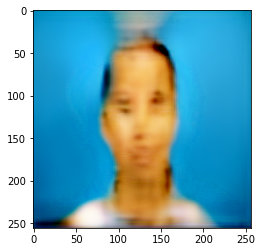

In [ ]:
plt.imshow(X)